# MNIST手書き数字分類をやってみる

<br>

**参考**
- [【入門】PyTorchの使い方をMNISTデータセットで学ぶ（15分）｜努力のガリレオ](https://dreamer-uma.com/pytorch-mlp-mnist/)

In [3]:
import torch
from torch import nn, optim
from torch.nn import functional as F

import matplotlib.pyplot as plt


---

## NNの定義

torch.nnを継承してnnを定義する

MNISTの手書き数字分類

In [4]:
input_size, output_size = 28*28, 10

class NeuralNetwork(nn.Module):
    def __init__(self):
        """コンストラクタ"""
        super().__init__() # 親クラスのコンストラクタ
        self.l1 = nn.Linear(input_size, 1024)
        self.l2 = nn.Linear(1024, 512)
        self.l3 = nn.Linear(512, output_size)

    def forward(self, z0):
        """順伝播"""
        z1 = F.relu(self.l1(z0))
        z2 = F.relu(self.l2(z1))
        z3 = self.l3(z2)
        return z3

`nn.Linear`は全結合層。kearsでいうDense

出力層にsoftmaxをかけていないが理由は後ほど


---

## インスタンス化

GPU(もしくはCPU)に転送するという作業が必要らしい

In [5]:
# gpu使用可能かどうか
torch.cuda.is_available()

False

インスタンス化し、CPUに転送(?)

In [58]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = NeuralNetwork().to(device)

model = NeuralNetwork()
model

NeuralNetwork(
  (l1): Linear(in_features=784, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=512, bias=True)
  (l3): Linear(in_features=512, out_features=10, bias=True)
)

In [9]:
# パラメータの確認
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0311, -0.0281,  0.0046,  ...,  0.0171, -0.0241,  0.0200],
         [ 0.0081, -0.0187,  0.0357,  ...,  0.0193,  0.0060,  0.0211],
         [-0.0333, -0.0110,  0.0097,  ...,  0.0161,  0.0105,  0.0142],
         ...,
         [-0.0220,  0.0138, -0.0270,  ..., -0.0032,  0.0169, -0.0163],
         [-0.0355, -0.0332,  0.0061,  ...,  0.0181,  0.0095,  0.0016],
         [-0.0270, -0.0225,  0.0140,  ..., -0.0252,  0.0083,  0.0238]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0272, -0.0142, -0.0066,  ..., -0.0052, -0.0164,  0.0022],
        requires_grad=True),
 Parameter containing:
 tensor([[ 2.7420e-03, -1.2877e-02, -6.4170e-03,  ...,  3.3783e-03,
          -1.1825e-02, -2.4582e-02],
         [-2.6368e-02,  1.9767e-02, -1.5704e-02,  ..., -1.9275e-02,
           2.3740e-02, -1.1299e-02],
         [-2.6046e-02,  1.5742e-02,  8.2186e-03,  ...,  1.8279e-02,
          -1.2141e-02,  3.0340e-02],
         ...,
         [-2.6334e-02, -6.4522e-0

順伝播の確認

適当な配列を用意して予測

In [10]:
x_sample = torch.randn(784)
result = model(x_sample)
result

tensor([-0.1888, -0.0457,  0.1630, -0.0362,  0.0409, -0.0165, -0.0064,  0.0362,
         0.0003,  0.0370], grad_fn=<AddBackward0>)

[torch.optim — PyTorch 1.11.0 documentation](https://pytorch.org/docs/stable/optim.html)

In [11]:
criterion = nn.CrossEntropyLoss() # 交差エントロピー
optimizer = optim.SGD(model.parameters(), lr=0.01) # SGD


---

## 学習

まず1エポックで行う過程を関数にする

In [12]:
def train(model, train_loader, criterion, optimizer):
    model.train() # 学習モードにする

    train_loss = 0.0
    num_train = 0

    for (images, labels) in train_loader:
        # batch数を累積
        num_train += len(labels)

        # viewで1次元配列に変更
        images = images.view(-1, 28*28)

        # 勾配をリセット
        optimizer.zero_grad()

        # 予測
        outputs = model(images)

        # lossを計算
        loss = criterion(outputs, labels)

        # 誤差逆伝播
        loss.backward()

        # パラメータ更新
        optimizer.step()

        # lossを累積
        train_loss += loss.item()

    train_loss = train_loss / num_train

    return train_loss

それを繰り返す関数

In [13]:
def run(model, train_loader, criterion, optimizer, num_epochs):

    train_loss_list = []
    # valid_loss_list = []

    for epoch in range(num_epochs):

        _train_loss = train(model, train_loader, criterion, optimizer)
        # _valid_loss = valid(model, train_loader, criterion, optimizer, device=device)

        print(f'Epoch [{epoch+1}], train_Loss : {_train_loss}')
        # print(f'Epoch [{epoch+1}], train_Loss : {_train_loss:.5f}, val_Loss : {_valid_loss:.5f}')
        
        train_loss_list.append(_train_loss)
        # valid_loss_list.append(_valid_loss)

    return train_loss_list #, valid_loss_list


---

## データを用意

MNISTの手書き数字をインポート

pytorchはTensorというデータの型を扱う。
torchvisionでやるとその型でインポートしてくれるので良き。

In [14]:
from torchvision.datasets import MNIST
from torchvision import transforms

[MNIST —Torchvision0.12ドキュメント](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST)

```
train = MNIST(
    root='./data', # データのファイルパス(ない場合は勝手にダウンロードされる)
    train=True, # 訓練データかラベルデータか
    transform=transforms.ToTensor(), # Tensor型に変換
    download=True)
```

In [15]:
train_data = MNIST(
    root='./data',
    train=True,
    transform=transforms.ToTensor(),
    download=False)

test_data = MNIST(
    root='./data',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

In [16]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [52]:
X_train = train_data.data.to(torch.float)
y_train = train_data.targets

X_test = test_data.data.to(torch.float)
y_test = test_data.targets

形状  
(データ数, 縦, 横)  
(60000, 28, 28)

In [18]:
X_train.size()

torch.Size([60000, 28, 28])

単一のデータを取ってくる

In [19]:
fig, label = train_data[0] # 0番目のデータの入力(画像)とラベル
print(f'fig shape : {fig.size()}, label : {label}')

fig shape : torch.Size([1, 28, 28]), label : 5


### DataLoader

torchで扱える型(?)。バッチサイズからジェネレータつくってくれるみたいな。

In [20]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False)


---

## 学習

学習させてみよう

In [21]:
num_epochs = 10
loss = run(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1], train_Loss : 0.008688710117340088
Epoch [2], train_Loss : 0.0071419483919938406
Epoch [3], train_Loss : 0.004398243167002996
Epoch [4], train_Loss : 0.0028802010079224906
Epoch [5], train_Loss : 0.002257584435741107
Epoch [6], train_Loss : 0.001936420392493407
Epoch [7], train_Loss : 0.0017411258260409037
Epoch [8], train_Loss : 0.0016095603187878927
Epoch [9], train_Loss : 0.0015136996015906333
Epoch [10], train_Loss : 0.001441659278422594


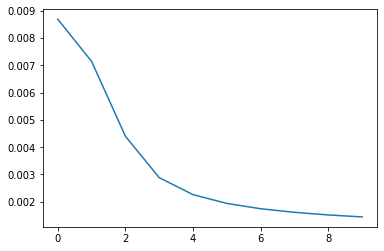

In [22]:
plt.plot(loss);


---

## 予測

作ったモデルで予測

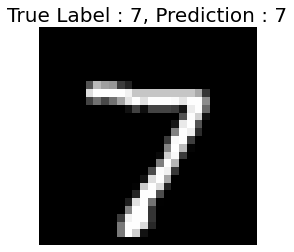

In [35]:
# datasetからサンプルを一つ取り出す
image, label = test_data[0:3]
image = image.view(-1, 28*28)

# 推論
prediction_label = torch.argmax(model(image))

fig, ax = plt.subplots()
ax.imshow(image.detach().numpy().reshape(28, 28), cmap='gray')

ax.axis('off')
ax.set_title(f'True Label : {label}, Prediction : {prediction_label}', fontsize=20)

plt.show()

In [56]:
images = X_test[0:3].view(-1, 28*28)

In [57]:
model(images)

tensor([[  217.3472, -1267.2115,    30.1375,   631.9653,  -588.2936,  -180.9477,
         -1619.2312,  2285.0881,  -124.3147,   975.0495],
        [  923.3291,  -544.4913,  1714.6488,   734.6901, -1671.5690,   746.4005,
          1091.7941, -1974.3965,   751.1757, -1490.7960],
        [-1050.8934,  1300.3416,   369.0532,   230.5735,  -591.3170,  -237.4660,
          -111.6042,   -24.3037,   327.5939,  -192.5440]],
       grad_fn=<AddmmBackward0>)